# Redborder Wrapped

### Import libraries

In [1]:
import os
import json
import requests
import urllib3
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter, defaultdict
from datetime import datetime
from dotenv import load_dotenv

# Disable warnings for self-signed certs
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

### Define the date range to filter the issues

In [ ]:
START_TIME = datetime.strptime('2025-01-01', '%Y-%m-%d')
END_TIME = datetime.strptime('2025-07-18', '%Y-%m-%d')

### Set up configuration

In [3]:
# Load .env
load_dotenv()
API_KEY = os.getenv('REDMINE_API_KEY')

# Constants and configuration
REDMINE_URL = 'https://redmine.redborder.lan'
PROJECT_ID = 'redborder_ng_core'
LIMIT = 100
RANGE_DATE = f'{START_TIME.strftime("%Y-%m-%d")} / {END_TIME.strftime("%Y-%m-%d")}'
offset = 0
all_issues = []
filtered_issues = []
headers = {
    'X-Redmine-API-Key': API_KEY
}

# Ensure the data directory exists
os.makedirs('data', exist_ok=True)

### Import and filter all the tasks

In [4]:
# Fetch all issues with pagination included
while True:
    params = {
        'project_id': PROJECT_ID,
        'status_id': '*',
        'limit': LIMIT,
        'offset': offset
    }
    response = requests.get(f'{REDMINE_URL}/issues.json', params=params, headers=headers, verify=False)
    
    if response.status_code != 200:
        print(f"Error: {response.status_code} - {response.text}")
        break

    data = response.json()
    issues = data.get('issues', [])
    all_issues.extend(issues)

    if len(issues) < LIMIT:
        break  # no more pages
    offset += LIMIT

# Filter issues created after the cutoff date
for issue in all_issues:
    created_str = issue.get('created_on')
    if created_str:
        created_at = datetime.strptime(created_str, '%Y-%m-%dT%H:%M:%SZ')
        if START_TIME < created_at <= END_TIME:
            filtered_issues.append(issue)

### Save the tasks in json and CSV format in data folder

In [5]:
# Save all issues to a JSON file
with open('data/raw_data.json', 'w', encoding='utf-8') as f:
    json.dump(filtered_issues, f, ensure_ascii=False, indent=2)

# Flatten issue data for CSV export
export_data = []
for issue in filtered_issues:
    export_data.append({
        'ID': issue.get('id'),
        'Subject': issue.get('subject'),
        'Created On': issue.get('created_on'),
        'Status': issue.get('status', {}).get('name'),
        'Assigned To': issue.get('assigned_to', {}).get('name', 'Unassigned'),
        'Tracker': issue.get('tracker', {}).get('name'),
        'Author': issue.get('author', {}).get('name'),
        'Updated On': issue.get('updated_on'),
    })

# Convert to DataFrame
df = pd.DataFrame(export_data)

# Save the data to CSV
csv_filename = f'raw_data.csv'
df.to_csv(f'data/{csv_filename}', index=False)

### Number of tasks per type

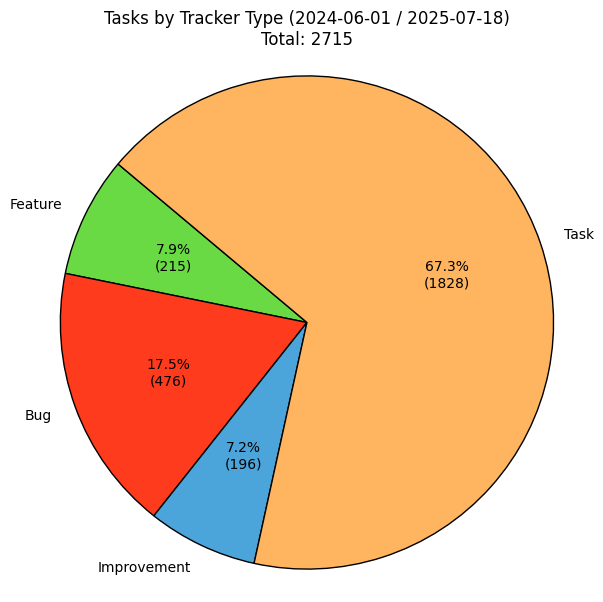

In [12]:
# Tracker types
tracker_types = ['Feature', 'Bug', 'Improvement', 'Task']
colors = ['#69DA43', '#FF3B1D', '#4BA5DB', '#FFB460']

# Count occurrences
tracker_counts = Counter()
for issue in filtered_issues:
    tracker = issue.get('tracker', {}).get('name')
    if tracker in tracker_types:
        tracker_counts[tracker] += 1

# Prepare data
sizes = [tracker_counts.get(t, 0) for t in tracker_types]
total_tasks = sum(sizes)

# Plot pie chart with percentages and absolute counts
def make_autopct(sizes):
    def autopct(pct):
        total = sum(sizes)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return autopct

plt.figure(figsize=(7, 7))
plt.pie(
    sizes,
    labels=tracker_types,
    autopct=make_autopct(sizes),
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title(f'Tasks by Tracker Type ({RANGE_DATE})\nTotal: {total_tasks}')
plt.axis('equal')
plt.savefig('data/tasks_per_type.png')
plt.show()

# Save to CSV
summary_df = pd.DataFrame({
    'Type': tracker_types + ['Total'],
    'Count': sizes + [total_tasks]
})
summary_df.to_csv('data/tasks_per_type.csv', index=False, encoding='utf-8')


#### Number of tasks created per person (excluding Task subtasks), grouped by type

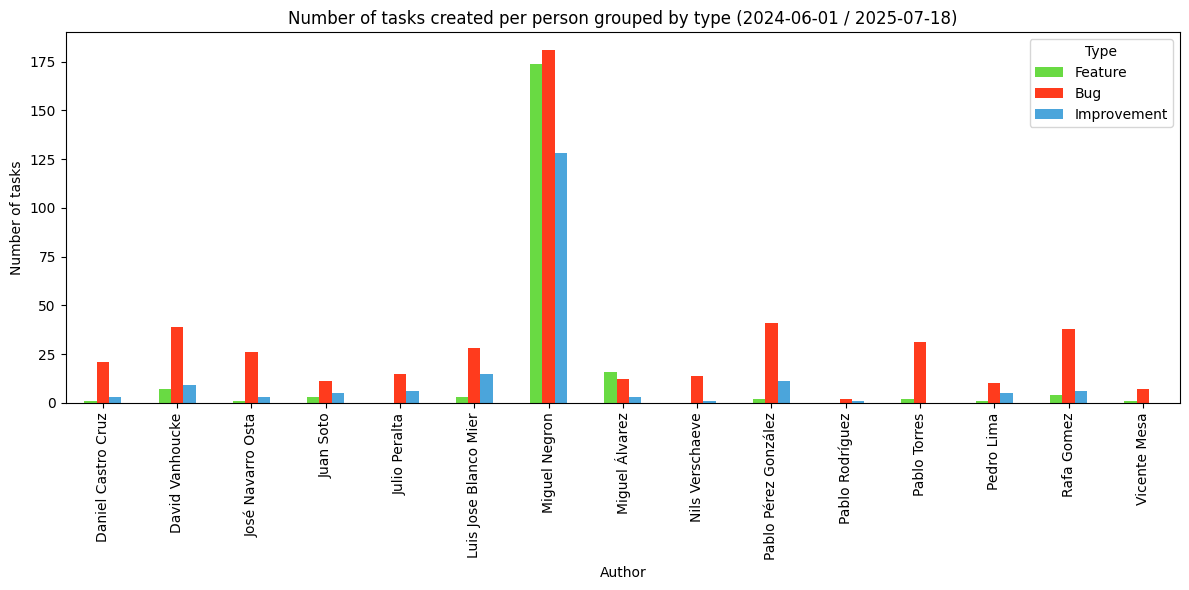

In [7]:
# Tracker types of interest
tracker_types = ['Feature', 'Bug', 'Improvement']
colors = ['#69DA43', '#FF3B1D', '#4BA5DB']

# Prepare data structure: author -> tracker type -> count
author_tracker_counts = defaultdict(lambda: {t: 0 for t in tracker_types})

for issue in filtered_issues:
    tracker = issue.get('tracker', {}).get('name')
    author = issue.get('author', {}).get('name', 'Unknown')
    if tracker in tracker_types:
        author_tracker_counts[author][tracker] += 1

# Prepare data for plotting
plot_df = pd.DataFrame.from_dict(author_tracker_counts, orient='index').fillna(0)

# Plot grouped bar chart
plot_df = plot_df.sort_index()
ax = plot_df.plot(kind='bar', stacked=False, figsize=(12, 6), color=colors)
plt.xlabel('Author')
plt.ylabel('Number of tasks')
plt.title(f'Number of tasks created per person grouped by type ({RANGE_DATE})')
plt.legend(title='Type')
plt.tight_layout()
plt.savefig('data/tasks_per_author_and_type.png')
plt.show()

# Save the data to CSV
plot_df.to_csv('data/tasks_per_author_and_type.csv', encoding='utf-8')

#### Number of Task subtasks per person (assigned_to), highlighting validation tasks

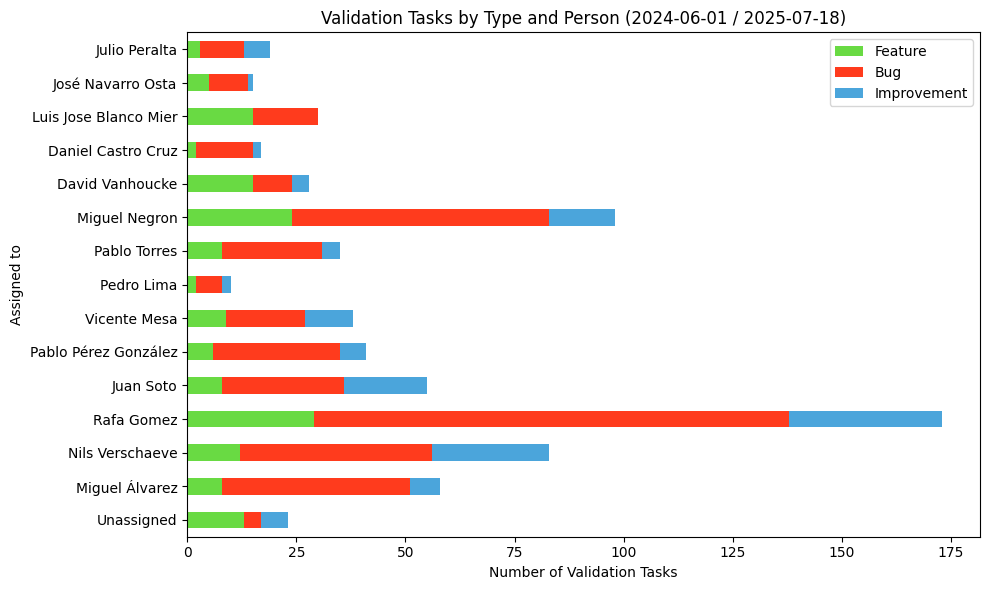

In [15]:
# Create a lookup by ID to access parent tasks quickly
issue_lookup = {issue['id']: issue for issue in filtered_issues}

# Nested counter: {person: {tracker_type: count}}
validation_by_person_and_type = defaultdict(Counter)

tracker_types = ['Feature', 'Bug', 'Improvement']
colors = ['#69DA43', '#FF3B1D', '#4BA5DB']

# Loop through validation tasks
for issue in filtered_issues:
    if issue.get('tracker', {}).get('name') == 'Task':
        if issue.get('subject') and 'valida' in issue['subject'].lower():
            assigned_to = issue.get('assigned_to', {}).get('name', 'Unassigned')

            parent_info = issue.get('parent')
            if parent_info:
                parent_id = parent_info['id']
                parent_issue = issue_lookup.get(parent_id)

                if parent_issue:
                    parent_tracker = parent_issue.get('tracker', {}).get('name')
                    if parent_tracker in tracker_types:
                        validation_by_person_and_type[assigned_to][parent_tracker] += 1

# Build a DataFrame for visualization
all_people = list(validation_by_person_and_type.keys())
data = {
    'Assigned to': all_people
}

# Add one column per tracker type
for tracker in tracker_types:
    data[tracker] = [validation_by_person_and_type[person].get(tracker, 0) for person in all_people]

df = pd.DataFrame(data)
df_plot = df.set_index('Assigned to')
df_plot[tracker_types].plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    color=colors
)

# Plot settings
plt.xlabel('Number of Validation Tasks')
plt.title(f'Validation Tasks by Type and Person ({RANGE_DATE})')
plt.tight_layout()
plt.savefig('data/validation_tasks_by_person_and_type.png')
plt.show()

# Save to CSV
df.to_csv('data/validation_tasks_by_person_and_type.csv', index=False, encoding='utf-8')


#### Number of non-validation tasks done per person (counting only one per parent)

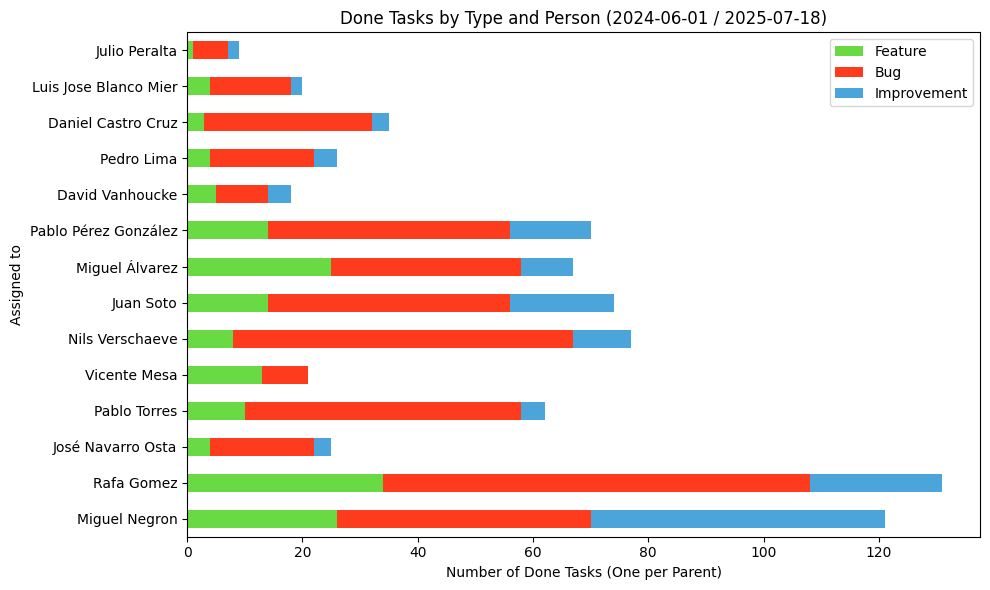

In [16]:
# The chart and CSV shows, for each person, the number of unique parent tasks (i.e., only one counted per parent id, even if there are multiple subtasks for the same parent).

# Tracker types and colors
tracker_types = ['Feature', 'Bug', 'Improvement']
colors = ['#69DA43', '#FF3B1D', '#4BA5DB']

# Build issue lookup by ID for parent access
issue_lookup = {issue['id']: issue for issue in filtered_issues}

# Filter non-validation done subtasks
done_tasks = [
    issue for issue in filtered_issues
    if issue.get('tracker', {}).get('name') == 'Task'
    and issue.get('status', {}).get('name') == 'Done'
    and not (issue.get('subject') and 'valida' in issue['subject'].lower())
]

# Counter: assigned_to -> tracker_type -> unique parent IDs
person_tracker_parents = defaultdict(lambda: defaultdict(set))

for issue in done_tasks:
    assigned_to = issue.get('assigned_to', {}).get('name', 'Unassigned')
    parent_id = issue.get('parent', {}).get('id')
    parent = issue_lookup.get(parent_id)

    # Only count known tracker types from the parent
    if parent:
        tracker = parent.get('tracker', {}).get('name')
        if tracker in tracker_types:
            person_tracker_parents[assigned_to][tracker].add(parent_id)
    else:
        # If no parent or parent unknown, skip
        continue

# Build the final DataFrame
assigned_people = list(person_tracker_parents.keys())
data = {'Assigned to': assigned_people}

for tracker in tracker_types:
    data[tracker] = [len(person_tracker_parents[person][tracker]) for person in assigned_people]

# Plot as stacked horizontal bar
df = pd.DataFrame(data)
df_plot = df.set_index('Assigned to')
df_plot[tracker_types].plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    color=colors
)

plt.xlabel('Number of Done Tasks (One per Parent)')
plt.title(f'Done Tasks by Type and Person ({RANGE_DATE})')
plt.tight_layout()
plt.savefig('data/done_tasks_by_person_and_type.png')
plt.show()

# Save to CSV
df.to_csv('data/done_tasks_by_person_and_type.csv', index=False, encoding='utf-8')

#### Top 10 validation tasks with the largest duration on being validated (closed_on - created_on)

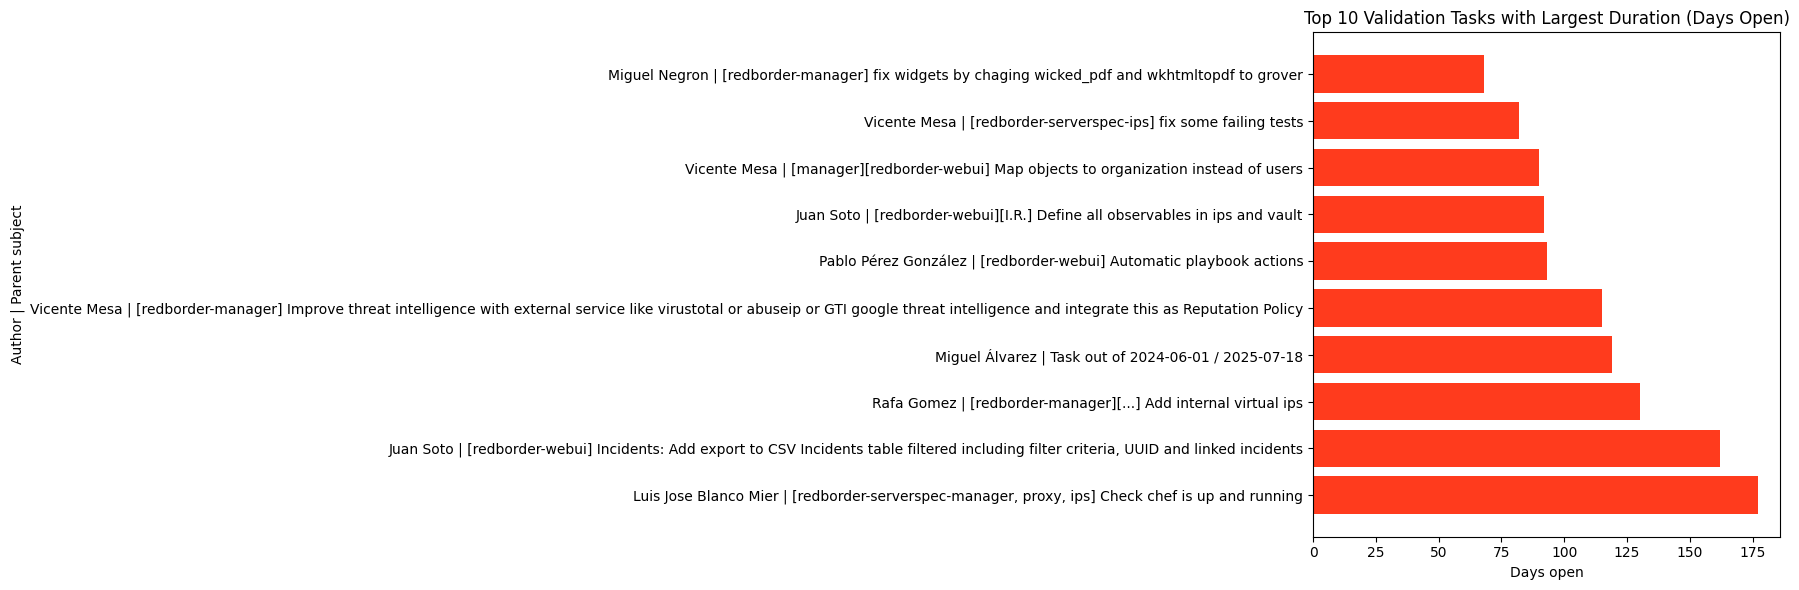

In [10]:
# Collect validation tasks with required fields
validation_tasks = []

for issue in filtered_issues:
    if issue.get('tracker', {}).get('name') == 'Task' and issue.get('subject') and 'valida' in issue['subject'].lower():
        created_on = issue.get('created_on')
        closed_on = issue.get('closed_on')
        author = issue.get('author', {}).get('name', 'Unknown')
        parent_id = issue.get('parent', {}).get('id')
        parent_subject = None
        # Find parent subject if parent_id exists
        if parent_id is not None:
            parent_issue = next((i for i in filtered_issues if i.get('id') == parent_id), None)
            if parent_issue:
                parent_subject = parent_issue.get('subject')
        if created_on and closed_on:
            try:
                created_dt = datetime.strptime(created_on, '%Y-%m-%dT%H:%M:%SZ')
                closed_dt = datetime.strptime(closed_on, '%Y-%m-%dT%H:%M:%SZ')
                diff_days = (closed_dt - created_dt).days
            except Exception:
                diff_days = None
            validation_tasks.append({
                'Author': author,
                'Created On': created_on,
                'Closed On': closed_on,
                'Days Open': diff_days,
                'Parent ID': parent_id,
                'Parent Subject': parent_subject
            })

# Create DataFrame and sort by difference
val_df = pd.DataFrame(validation_tasks)
val_df = val_df.sort_values(by='Days Open', ascending=False)

# Plot top 10
top10 = val_df.head(10)
plt.figure(figsize=(18, 6))
plt.barh(top10['Author'] + ' | ' + top10['Parent Subject'].fillna(f'Task out of {RANGE_DATE}'), top10['Days Open'], color='#FF3B1D')
plt.xlabel('Days open')
plt.ylabel('Author | Parent subject')
plt.title('Top 10 Validation Tasks with Largest Duration (Days Open)')
plt.tight_layout()
plt.savefig('data/validation_tasks_duration_top10.png')
plt.show()

# Save the data to CSV
val_df.to_csv('data/validation_tasks_duration.csv', index=False, encoding='utf-8')

#### Top 10 Feature, Bug, and Improvement tasks with the largest duration (closed_on - created_on)

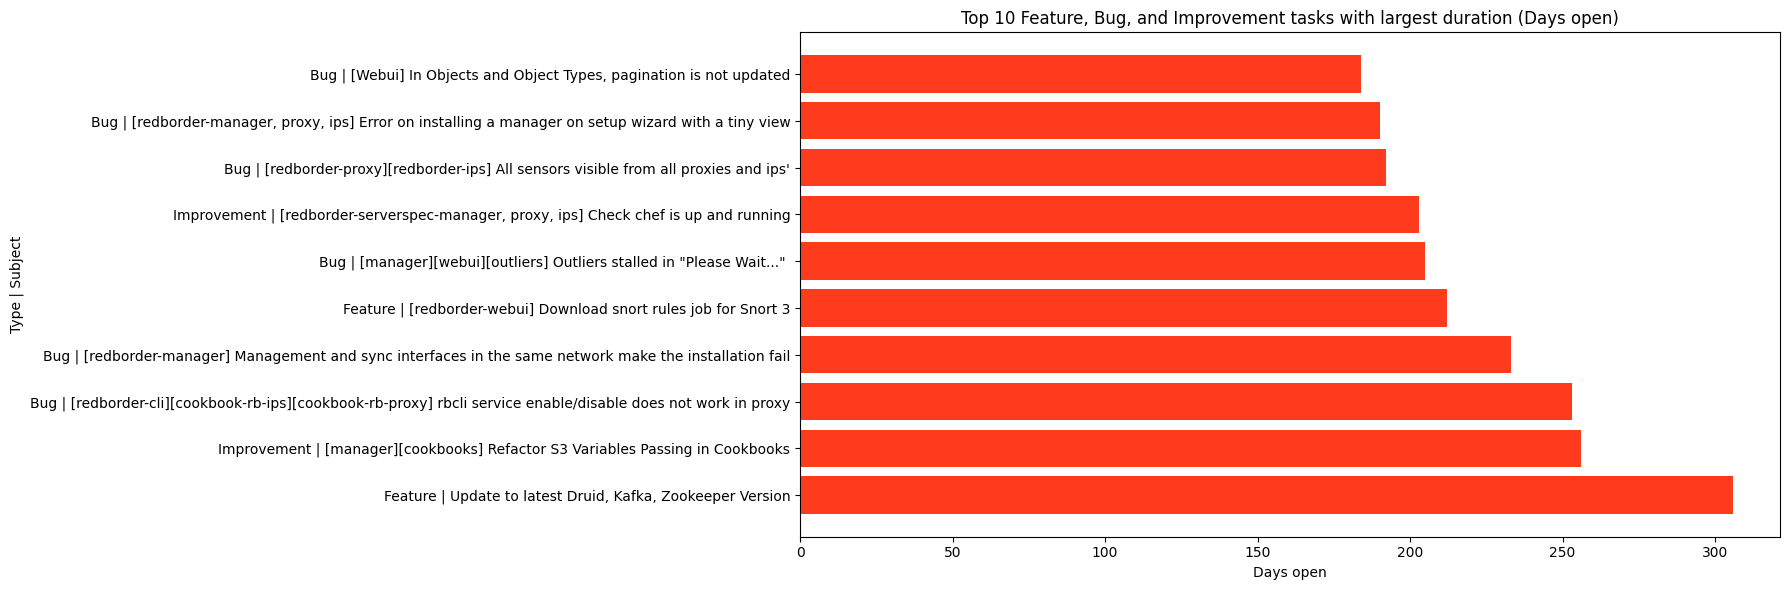

In [11]:
# Collect Feature, Bug, and Improvement tasks
tracker_types = ['Feature', 'Bug', 'Improvement']
tasks = []

for issue in filtered_issues:
    tracker = issue.get('tracker', {}).get('name')
    # done_ratio = issue.get('done_ratio', 0)
    if tracker in tracker_types:
        created_on = issue.get('created_on')
        closed_on = issue.get('closed_on')
        subject = issue.get('subject', '')
        if created_on and closed_on:
            try:
                created_dt = datetime.strptime(created_on, '%Y-%m-%dT%H:%M:%SZ')
                closed_dt = datetime.strptime(closed_on, '%Y-%m-%dT%H:%M:%SZ')
                diff_days = (closed_dt - created_dt).days
            except Exception:
                diff_days = None
            tasks.append({
                'Type': tracker,
                'Subject': subject,
                'Created On': created_on,
                'Closed On': closed_on,
                'Days Open': diff_days
            })

# Create DataFrame and sort by difference
tasks_df = pd.DataFrame(tasks)
tasks_df = tasks_df.sort_values(by='Days Open', ascending=False)

# Plot top 10
plot_top = tasks_df.head(10)
plt.figure(figsize=(18, 6))
plt.barh(plot_top['Type'] + ' | ' + plot_top['Subject'].fillna(f'Task out of {RANGE_DATE}'), plot_top['Days Open'], color='#FF3B1D')
plt.xlabel('Days open')
plt.ylabel('Type | Subject')
plt.title('Top 10 Feature, Bug, and Improvement tasks with largest duration (Days open)')
plt.tight_layout()
plt.savefig('data/feature_bug_improvement_tasks_duration_top10.png')
plt.show()

# Save the data to CSV
tasks_df.to_csv('data/feature_bug_improvement_tasks_duration.csv', index=False, encoding='utf-8')